# Prediction on new data

> Notebook to predict the segmentation masks on new data using pretrained or customized models. 

This notebook is optmizied to be executed on [Google Colab](https://colab.research.google.com).

* Press the the *play* butten to execute the cells. It will show up between \[     \] on the left side of the code cells. 
* Run the cells consecutively. Skip cells that do not apply for your case.
* Use Firefox or Google Chrome if you want to upload files

In [ ]:
#@title Set up environment
#@markdown Please run this cell to get started.
%load_ext autoreload
%autoreload 2
try:
    from google.colab import files, drive
except ImportError:
    pass
try:
    import deepflash2
except ImportError:
    !pip install -q deepflash2
import zipfile
import imageio
from fastai.vision.all import *
from deepflash2.all import *

## Provide Data

### Required data structure

- __One folder for images__ (different from training image folder!)

_Examplary structure:_

* [folder] images_new
  * [file] 0001.tif
  * [file] 0002.tif

### Working on _Google Colab_ (recommended)

This section allows you to upload a *zip* folder or connect to your _Google Drive_.

#### Connect to _Google Drive_ (recommended)

- The folder in your drive must contain all images in one folder.
- See [here](https://support.google.com/drive/answer/2375091?co=GENIE.Platform%3DDesktop&hl=en) how to organize your files in _Google Drive_.
- See this [stackoverflow post](https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory) for browsing files with the file browser

In [ ]:
#@markdown Provide the path to the folder on your _Google Drive_
try:
    drive.mount('/content/drive')
    path = "/content/drive/My Drive/data" #@param {type:"string"}
    path = Path(path)
    #@markdown Example: "/content/drive/My Drive/data"
except:
    print("Warning: Connecting to Google Drive only works on Google Colab.")
    pass

#### Upload a _zip_ file

- The *zip* file must contain all images in one folder
- See [here](https://www.hellotech.com/guide/for/how-to-zip-a-file-mac-windows-pc) how to _zip_ files on Windows or Mac.

In [ ]:
#@markdown Run to upload a *zip* file
path = Path('data')
try:
    u_dict = files.upload()
    for key in u_dict.keys():
        unzip(path, key)
except:
    print("Warning: File upload only works on Google Colab.")
    pass

### Local Installation

If you're working on your local machine or server, provide a path to the correct folder.

In [ ]:
#@markdown Provide path (either relative to notebook or absolute) and run cell
path = "my_data" #@param {type:"string"}
path = Path(path)
#@markdown Example: "new_images"

### Try with sample data

If you don't have any data available yet, try our sample data

In [ ]:
#@markdown Run to use sample files
path = Path('sample_data_cFOS')
url = "https://github.com/matjesg/deepflash2/releases/download/model_library/wue1_cFOS_small.zip"
urllib.request.urlretrieve(url, 'sample_data_cFOS.zip')
unzip(path, 'sample_data_cFOS.zip')

## Load data

In [ ]:
#@markdown Provide your parameters according to your provided data
image_folder = "images" #@param {type:"string"}
files = get_image_files(path/image_folder)
#@markdown Number of classes: e.g., 2 for binary segmentation (foreground and background class)
n_classes = 2 #@param {type:"integer"}
ds = TileDataset(files, n_classes=n_classes)

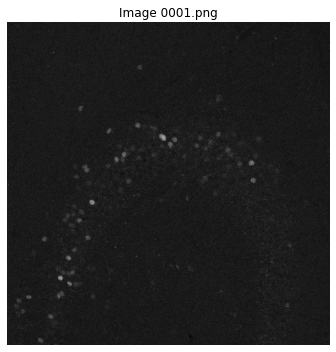

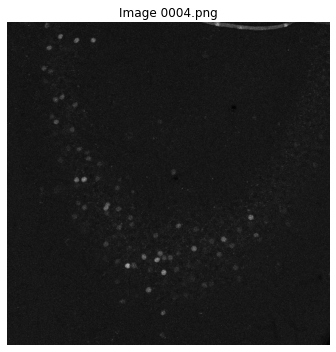

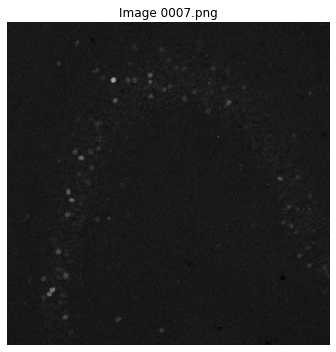

In [ ]:
#@markdown Run to show data. { run: "auto" }
#@markdown Use the slider to control the number of displayed images
first_n = 3 #@param {type:"slider", min:1, max:100, step:1}
ds.show_data(max_n=first_n, figsize=(5,5), overlay=False)

## Model Defintion

Select model [model architecture](https://matjesg.github.io/deepflash2/models.html#U-Net-architectures)

In [ ]:
#@markdown { run: "auto" }
model_arch = 'unet_deepflash2' #@param ["unet_deepflash2",  "unet_falk2019", "unet_ronnberger2015"]
n_channels = ds.get_data(max_n=1)[0].shape[-1]
model = torch.hub.load('matjesg/deepflash2', model_arch, pretrained=False, n_classes=ds.c, in_channels=n_channels, force_reload=True)
model_list = L()

Downloading: "https://github.com/matjesg/deepflash2/archive/master.zip" to /home/firstusr/.cache/torch/hub/master.zip


### Select [pretraind](https://matjesg.github.io/deepflash2/) model weights

#### Using customized weights (recommended)
- Customize your models in the [Model Training Notebook](https://matjesg.github.io/deepflash2/train.html)

In [ ]:
#@markdown Run to select models from _Google Colab_. { run: "auto" }
#@markdown Models should be saved in the 'models' folder of your provided path.
models_folder = "models" #@param {type:"string"}
model_list = get_files(path/models_folder, extensions='.pth')
print('Found models', model_list)

Found models (#2) [Path('sample_data_cFOS/models/model1.pth'),Path('sample_data_cFOS/models/model2.pth')]


In [ ]:
#@markdown Run to upload models. **CAN BE VERY SLOW**. { run: "auto" }
try:
    u_dict = files.upload()
    model_list += [Path(u) for u in u_dict]
except:
    print("Warning: File upload only works on Google Colab.")
    pass
print('Found models', model_list)

Found models (#2) [Path('sample_data_cFOS/models/model1.pth'),Path('sample_data_cFOS/models/model2.pth')]


#### Using pretrained weights from deepflash2
- See [Model Libray](https://matjesg.github.io/deepflash2/model_library.html) 

In [ ]:
pretrained_weights = "wue1_cFOS" #@param ["cFOS", "Parv"]
model = torch.hub.load('matjesg/deepflash2', model_arch, pretrained=True, dataset=pretrained_weights, n_classes=ds.c, in_channels=n_channels)
model_list = L(Path(f'/home/firstusr/.cache/torch/hub/checkpoints/{pretrained_weights}.pth'))

Using cache found in /home/firstusr/.cache/torch/hub/matjesg_deepflash2_master


## Prediction

In [ ]:
#@markdown Run to predict segmentation masks for new images.
res, res_mc = {}, {}
for m in progress_bar(model_list):
    print(f'Model {m.stem}')
    dls = DataLoaders.from_dsets(ds, batch_size=4 ,shuffle=False, drop_last=False)
    state_dict = torch.load(m)
    model.load_state_dict(state_dict, strict=False)
    if torch.cuda.is_available(): dls.cuda(), model.cuda()
    learn = Learner(dls, model, loss_func=0)#.to_fp16()
    
    print(f'Predicting segmentation masks')
    smxs, segs, _ = learn.predict_tiles(dl=dls.train)   
    print(f'Predicting uncertainty maps')
    smxs_mc, segs_mc, std = learn.predict_tiles(dl=dls.train, mc_dropout=True, n_times=10)
    
    #TODO Save results not using RAM
    for i, file in enumerate(files):
        res[(m.stem, file)] = smxs[i], segs[i]
        res_mc[(m.stem, file)] = smxs_mc[i], segs_mc[i], std[i]

Model wue1_cFOS
Predicting segmentation masks


Predicting uncertainty maps


## Ensembling

Here you can validate your results. 
If you choose to only train one model (`n_models = 1`), ensemble and model results will be the same.

In [ ]:
#@markdown Create folders to save the resuls. They will be created at your provided 'path'.
pred_dir = 'preds' #@param {type:"string"}
pred_path = path/pred_dir/'ensemble'
pred_path.mkdir(parents=True, exist_ok=True)
uncertainty_dir = 'uncertainties' #@param {type:"string"}
uncertainty_path = path/uncertainty_dir/'ensemble'
uncertainty_path.mkdir(parents=True, exist_ok=True)

#@markdown Define `filetype` to save the predictions and uncertainties. All common filetypes are supported.
filetype = 'png' #@param {type:"string"}

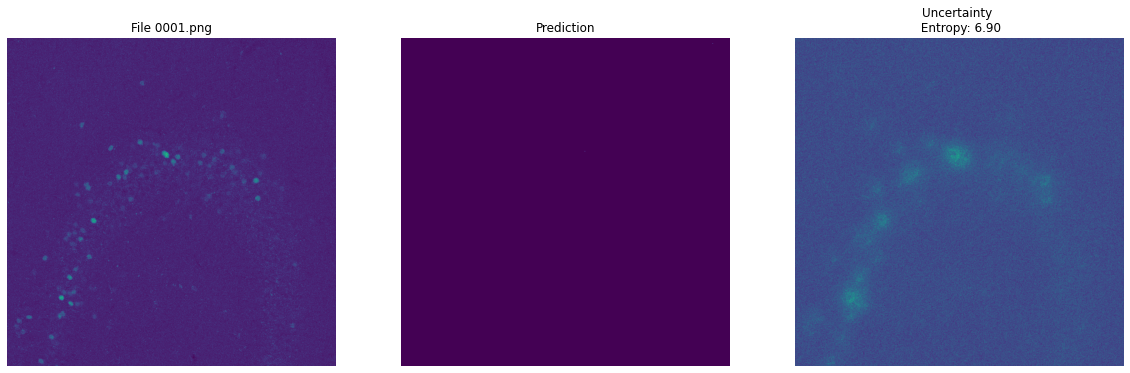

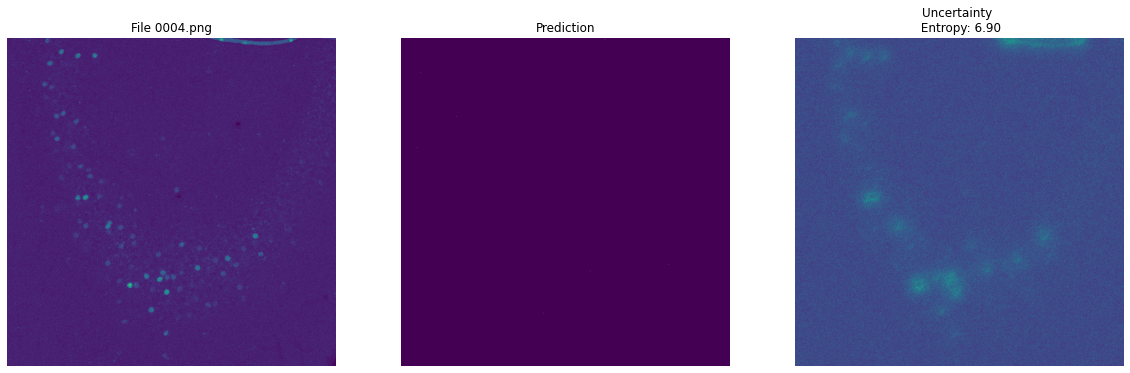

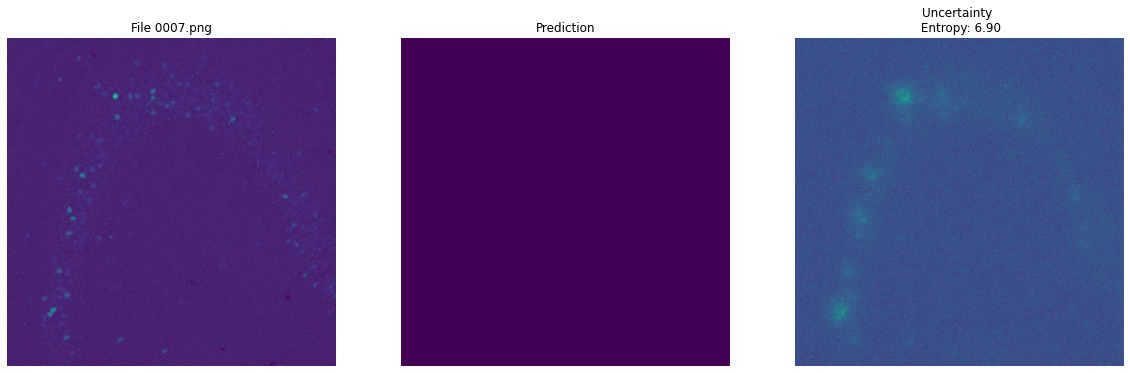

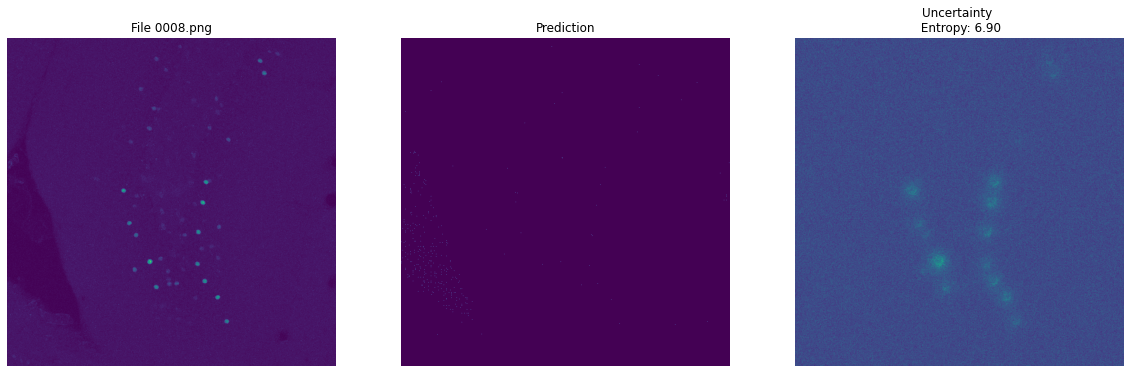

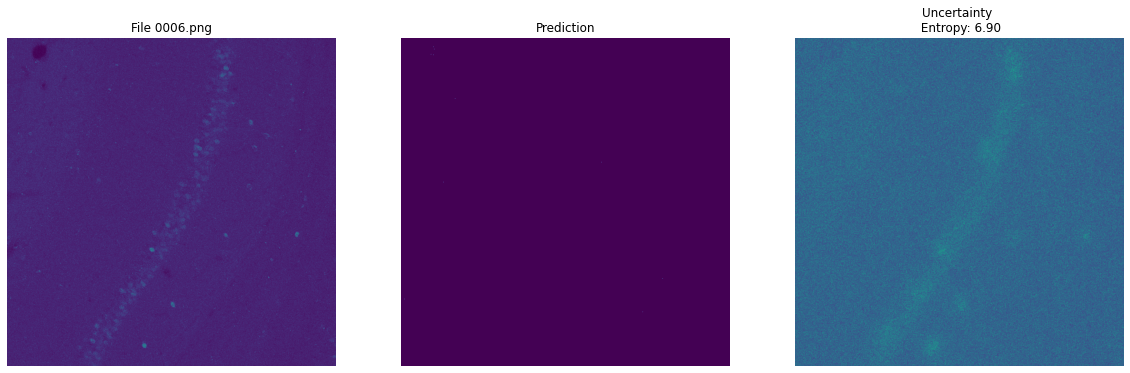

In [ ]:
#@markdown Show and save ensemble results
res_list = []
for file in files:
    img = ds.get_data(file)[0]
    msk = ds.get_data(file, mask=True)[0]
    pred = ensemble_results(res, file)
    pred_std = ensemble_results(res_mc, file, std=True)
    df_tmp = pd.Series({'file' : file.name, 'entropy': mean_entropy(pred_std)})
    plot_results(img, pred, pred_std, df=df_tmp)
    res_list.append(df_tmp)
    imageio.imsave(pred_path/f'{file.name}_pred.{filetype}', pred.astype(np.uint8) if np.max(pred)>1 else pred.astype(np.uint8)*255)
    imageio.imsave(uncertainty_path/f'{file.name}_uncertainty.{filetype}', pred_std.astype(np.uint8)*255)
df_res = pd.DataFrame(res_list)
df_res.to_csv(path/'ensemble_results.csv', index=False)

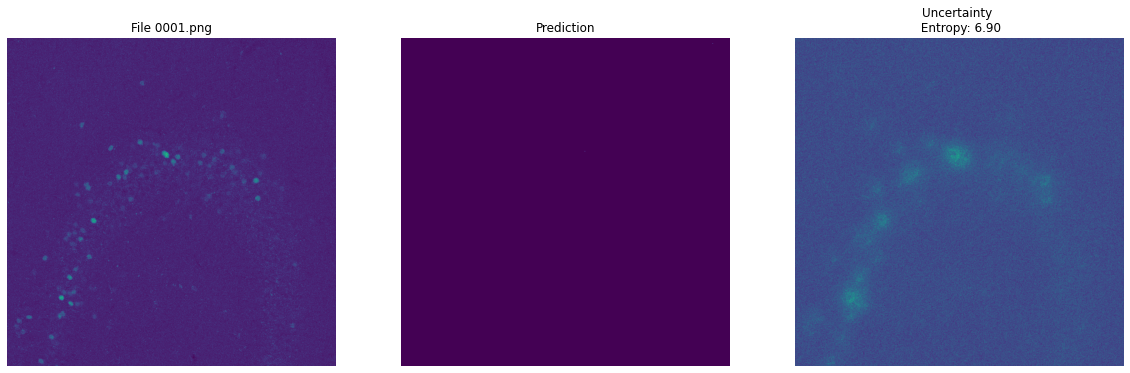

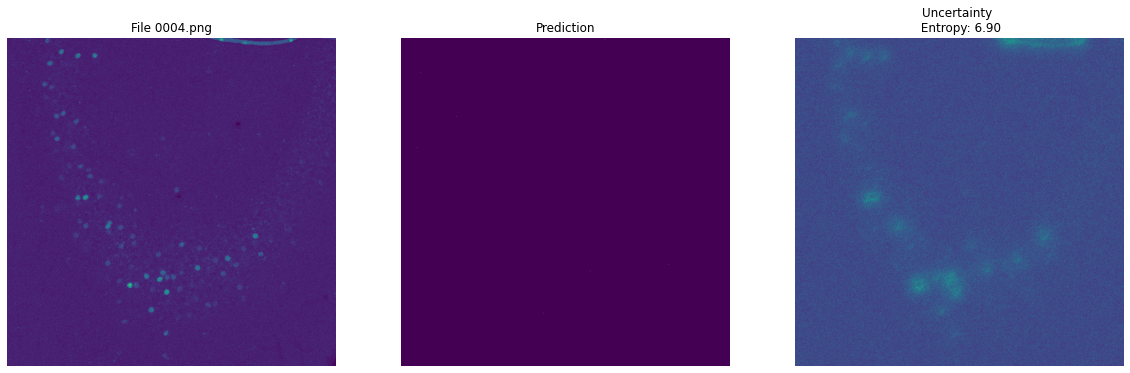

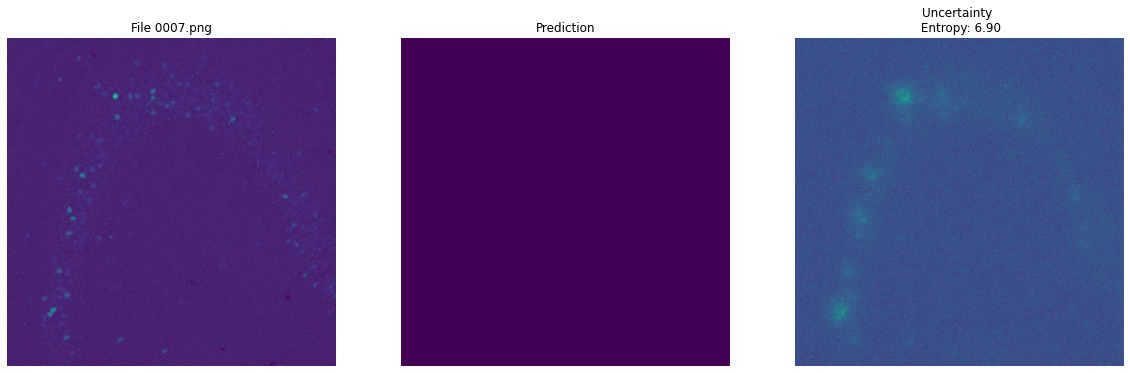

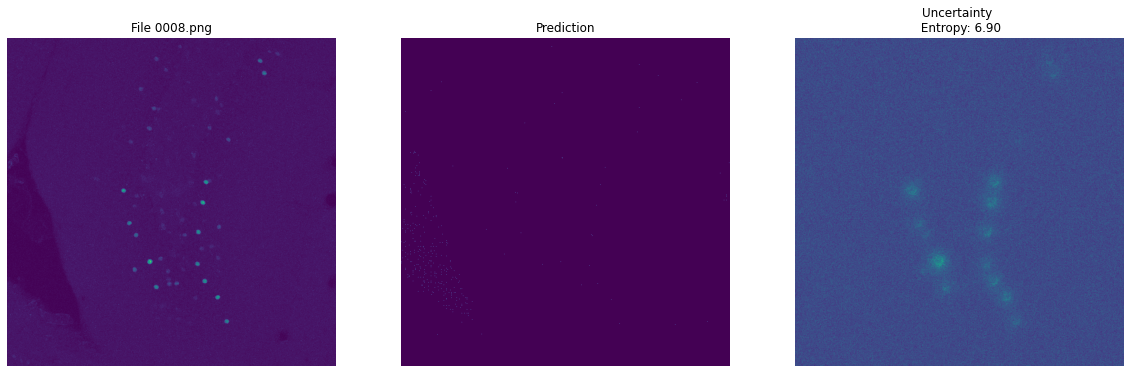

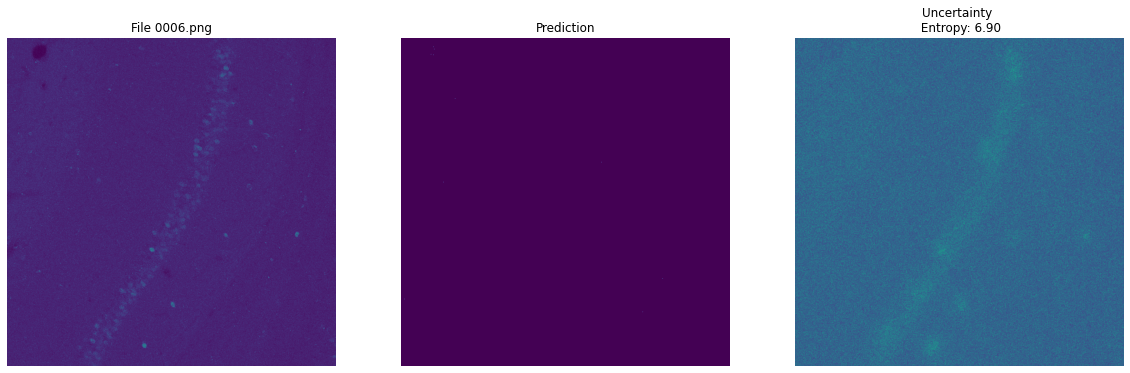

In [ ]:
#@markdown Show and save (single) model results { run: "auto" }
model_number = 1 #@param {type:"slider", min:1, max:5, step:1}
model_name = model_list[model_number-1].stem
pred_path = path/pred_dir/model_name
pred_path.mkdir(parents=True, exist_ok=True)
uncertainty_path = path/uncertainty_dir/model_name
uncertainty_path.mkdir(parents=True, exist_ok=True)
res_list = []
for file in files:
    img = ds.get_data(file)[0]
    pred = res[(model_name,file)][1]
    pred_std = res_mc[(model_name,file)][2][...,0]
    df_tmp = pd.Series({'file' : file.name, 'entropy': mean_entropy(pred_std)})
    plot_results(img, pred, pred_std, df=df_tmp)
    res_list.append(df_tmp)
    imageio.imsave(pred_path/f'{file.name}_pred.{filetype}', pred.astype(np.uint8) if np.max(pred)>1 else pred.astype(np.uint8)*255)
    imageio.imsave(uncertainty_path/f'{file.name}_uncertainty.{filetype}', pred_std.astype(np.uint8)*255)
df_res = pd.DataFrame(res_list)
df_res.to_csv(path/f'{model_name}_results.csv', index=False)

## Download Section

To download validation predictions and uncertainties, you first need to execute Section _Validate models and ensembles_.

_Note: If you're connected to *Google Drive*, the models are automatically saved to your drive._

In [ ]:
#@markdown Download predicitions { run: "auto" }
out_name = 'predictions.zip'
with zipfile.ZipFile(path/out_name, 'w') as zf:
    for f in get_image_files(path/pred_dir):
          zf.write(f)
try:
    files.download(path/out_name)
except:
    print("Warning: File download only works on Google Colab.")
    pass

In [ ]:
#@markdown Download uncertainties { run: "auto" }
out_name = 'uncertainties.zip'
with zipfile.ZipFile(path/out_name, 'w') as zf:
    for f in get_image_files(path/pred_dir):
          zf.write(f)
try:
    files.download(path/out_name)
except:
    print("Warning: File download only works on Google Colab.")
    pass

In [ ]:
#@markdown Download result analysis '.csv' files
out_name = 'results.zip'
with zipfile.ZipFile(path/out_name, 'w') as zf:
    for f in get_files(path, extensions='.csv'):
          zf.write(f)
try:
    files.download(path/out_name)
except:
    print("Warning: File download only works on Google Colab.")
    pass